In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from collections import Counter
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.interpolate import interp1d
from sklearn.utils import resample
from scipy.stats import wilcoxon
import math
import matplotlib.cm as cm

## Load and explore the bile acid data 

In [3]:
#Read the file 

bile_acid = pd.read_csv("Bile acid metabolomics.csv")

In [4]:
# Map the sample ID to the time point 

timepoint_map = {
    'A': 'Baseline',
    'B': 'Week 2',
    'C': 'Week 4',
    'D': 'Week 8'
}

bile_acid['Timepoint'] = bile_acid['SampleID'].str[-1].map(timepoint_map)

In [8]:
#Filter Data according to timepoints

filtered_b2 = bile_acid[bile_acid['Timepoint'].isin(['Baseline', 'Week 2'])]
filtered_b4 = bile_acid[bile_acid['Timepoint'].isin(['Baseline', 'Week 4'])]
filtered_b8 = bile_acid[bile_acid['Timepoint'].isin(['Baseline', 'Week 8'])]
# Display the result
filtered_b4.head(30)

,SampleID,5-Cholenic Acid-3-beta-ol,3-Ketocholanic Acid,Isolithocholic Acid,Isoallolithocholic Acid,5-beta-Cholenic Acid-7-alpha-ol-3-one,5-alpha-Cholanic Acid-3-alpha-ol-6-one,3-alpha-Hydroxy-7 Ketolithocholic Acid,3-alpha-Hydroxy-12 Ketolithocholic Acid,Murocholic Acid,...,Glycoursodeoxycholic Acid-3-Sulfate,23-Norcholic Acid,6-Oxolithocholic Acid,5-beta-Cholanic Acid 12-alpha-ol-3-one,5-alpha-Cholanic Acid-3-one,Lithocholic Acid,"3,7-Diketocholanic Acid|3,6-Diketocholanic Acid|3,12-Diketocholanic Acid",12-Ketochenodeoxycholic acid|7-Ketodeoxycholic acid,Cholic acid|Ursocholic acid,Timepoint
0,1A,24714.802286,2.486340e+06,1.726029e+07,2.968300e+06,1.350017e+04,55246.013253,5.033034e+04,3.237215e+06,7.536789e+04,...,7.487345e+03,129853.183210,57313.762280,1.655114e+06,166807.347919,5.438780e+07,164840.479466,2.947933e+04,5.305731e+04,Baseline
1,2A,35931.172968,3.161716e+03,2.959778e+03,9.841400e+02,1.634303e+04,4645.240663,5.985989e+05,7.118947e+04,1.301774e+06,...,4.370474e+04,2428.956674,4483.908266,2.178728e+04,592.326550,2.138802e+05,3784.990371,3.835766e+05,2.508685e+06,Baseline
2,3A,21263.685502,5.998576e+05,5.876149e+06,1.537954e+04,2.534402e+04,19286.796552,3.429604e+05,5.449764e+06,1.377286e+06,...,3.136491e+03,41415.526403,19877.876282,3.080819e+06,7295.708362,7.446428e+07,66744.234930,1.385989e+05,3.291237e+06,Baseline
3,4A,33089.107070,4.790872e+06,2.597288e+07,2.984533e+06,8.859639e+03,35022.701022,6.453529e+04,7.286673e+06,9.491215e+04,...,4.570927e+03,117671.532755,70766.191603,2.343040e+06,114274.397091,1.011556e+08,367832.825346,4.632583e+04,3.323280e+05,Baseline
4,5A,27823.105661,8.383866e+05,4.820237e+06,1.997520e+05,3.092408e+04,21324.930390,6.606840e+05,8.319890e+05,5.269916e+05,...,2.026247e+05,9982.564293,23095.277602,1.810345e+05,9143.064369,3.614314e+07,21219.132878,2.468609e+05,2.869606e+06,Baseline
5,6A,165931.138815,2.618862e+03,1.435778e+04,7.357662e+02,4.332300e+04,64520.558408,5.333389e+04,5.898122e+03,9.402993e+04,...,6.691886e+04,23877.651297,1246.058091,8.097789e+03,2682.676814,3.351469e+04,3973.716430,1.614899e+05,4.008678e+07,Baseline
6,7A,305869.187593,3.671383e+05,1.099234e+06,5.654775e+03,2.805119e+04,35303.847432,7.350935e+05,6.988815e+05,1.658409e+06,...,3.631813e+06,32438.821576,227056.022529,2.290330e+05,2575.908404,2.692093e+07,13223.830764,1.845758e+05,3.626909e+06,Baseline
7,8A,9519.114985,1.531703e+06,9.277376e+06,2.846933e+05,4.216444e+03,54743.297937,4.737691e+04,4.687839e+06,2.794621e+05,...,3.780303e+03,69006.566201,192389.287265,1.707155e+06,13121.320664,5.416240e+07,99340.500889,1.827741e+04,9.877883e+04,Baseline
8,9A,26645.401460,3.984953e+05,1.817083e+06,1.734768e+04,5.160484e+03,4302.089486,4.599272e+04,4.241623e+04,1.773260e+04,...,5.204695e+03,5058.716848,8982.970901,1.605208e+04,16148.224053,1.067126e+07,4365.352822,2.692013e+04,5.105027e+05,Baseline
9,10A,16451.696848,4.059009e+03,2.469560e+04,3.506138e+03,1.384424e+03,8053.659854,8.274418e+04,5.771203e+04,1.904849e+04,...,3.577969e+03,4753.067114,18473.513032,1.079426e+04,245.572952,2.896722e+05,2424.220636,2.162612e+05,1.534353e+06,Baseline


In [10]:
# Remove 2A patient 

filtered_b4_clean = filtered_b4.drop(1).reset_index(drop=True)

In [12]:
# Normalize and Scale for PCA

#baseline vs week 2
y_2 = filtered_b2["Timepoint"]
x_2 = filtered_b2.drop(columns= ["Timepoint", "SampleID"])

#baseline vs week 4 
y_4 = filtered_b4["Timepoint"]
x_4 = filtered_b4.drop(columns= ["Timepoint", "SampleID"])

#baseline vs week 8

y_8 = filtered_b8["Timepoint"]
x_8 = filtered_b8.drop(columns= ["Timepoint", "SampleID"])

#all 

y = bile_acid['Timepoint']
x = bile_acid.drop(columns= ["Timepoint", "SampleID"])

In [14]:
# Log transform the xs

log_X2 = np.log1p(x_2)
log_X4 = np.log1p(x_4)
log_X8 = np.log1p(x_8)
log_X = np.log1p(x)

## Selected features 

In [17]:
#baseline vs week 4 
y_4_ml = filtered_b4_clean["Timepoint"]
x_4_ml = filtered_b4_clean.drop(columns= ["Timepoint", "SampleID"])

In [19]:
log_x4_ml = np.log1p(x_4_ml)

In [21]:
#Selected features 

selected_features = ['Glycochenodeoxycholic Acid-3-Sulfate ', '3-alpha-Hydroxy-7 Ketolithocholic Acid', 'Deoxycholic Acid',
                     'Taurodeoxycholic Acid', '5-beta-Cholanic Acid 12-alpha-ol-3-one', 'Glycochenodeoxycholic Acid', 
                     'Glycodeoxycholic Acid', '3-alpha-Hydroxy-12 Ketolithocholic Acid', '12-Ketochenodeoxycholic acid|7-Ketodeoxycholic acid',
                     'Isolithocholic Acid', 'Hyocholic acid', 'Cholic acid|Ursocholic acid', 'Glycocholic Acid', '6-Oxolithocholic Acid',
                     '5-beta-Cholanic Acid-3-beta, 12-alpha-diol', 'Lithocholic Acid', 'Murocholic Acid', 'Glycoursodeoxycholic Acid',
                     '3-Ketocholanic Acid', 'Glycohyocholic Acid', 'Hyodeoxycholic Acid', 'Glycocholic Acid-3-Sulfate ']
log_x4_ml = log_x4_ml[selected_features]

In [23]:
log_x4_ml.head()

,Glycochenodeoxycholic Acid-3-Sulfate,3-alpha-Hydroxy-7 Ketolithocholic Acid,Deoxycholic Acid,Taurodeoxycholic Acid,5-beta-Cholanic Acid 12-alpha-ol-3-one,Glycochenodeoxycholic Acid,Glycodeoxycholic Acid,3-alpha-Hydroxy-12 Ketolithocholic Acid,12-Ketochenodeoxycholic acid|7-Ketodeoxycholic acid,Isolithocholic Acid,...,Glycocholic Acid,6-Oxolithocholic Acid,"5-beta-Cholanic Acid-3-beta, 12-alpha-diol",Lithocholic Acid,Murocholic Acid,Glycoursodeoxycholic Acid,3-Ketocholanic Acid,Glycohyocholic Acid,Hyodeoxycholic Acid,Glycocholic Acid-3-Sulfate
0,9.038048,10.826383,17.933649,10.532913,14.319381,11.254241,11.812117,14.990224,10.291478,16.663919,...,10.952453,10.956314,15.569591,17.811650,11.230150,9.580544,14.726323,7.963807,13.318586,9.361361
1,8.166334,12.745373,18.550651,11.148002,14.940706,13.710150,12.945745,15.511083,11.839347,15.586412,...,13.941824,9.897413,16.912942,18.125830,14.135626,11.131524,13.304449,7.314097,12.407302,7.298499
2,8.409108,11.074983,18.329442,11.269919,14.666960,13.159581,12.567009,15.801558,10.743477,17.072564,...,12.920475,11.167151,16.253200,18.432170,11.460718,10.324922,15.382223,7.507024,13.643703,8.199958
3,9.660788,13.401033,16.525979,11.193753,12.106448,12.326135,11.375220,13.631576,12.416584,15.388334,...,12.332585,10.047427,13.860633,17.402998,13.174942,13.439876,13.639236,7.445140,12.098603,8.621085
4,13.601506,10.884346,11.705464,9.928340,8.999470,13.437477,9.518173,8.682559,11.992204,9.572117,...,14.233168,7.128543,9.618845,10.419769,11.451379,9.505568,7.870877,10.053114,7.885984,14.107473


## LASSO WITH LPOCV

In [26]:
# map y to 0 baseline and 1 to week 4 

y_4_ml = y_4_ml.map({'Baseline': 0, 'Week 4': 1})

In [28]:
patients = filtered_b4_clean['SampleID'].unique()

y_true_LA = []
y_pred_prob_LA = []
selected_genes_list_LA = []

for patient in patients:
    # Get boolean mask for train/test split
    test_mask = (filtered_b4_clean['SampleID'] == patient)
    train_mask = ~test_mask

    # Apply masks to feature matrix and labels
    X_train, X_test = log_x4_ml[train_mask], log_x4_ml[test_mask]
    y_train, y_test = y_4_ml[train_mask], y_4_ml[test_mask]

    # Inner loop for lambda selection (Elastic Net)
    inner_model_LA = LogisticRegressionCV(
        Cs=10,                      # Number of inverse lambdas to try
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[1.0],            
        scoring='accuracy',
        max_iter=10000,
        n_jobs=-1
    )

    pipeline_LA = make_pipeline(StandardScaler(), inner_model_LA)
    pipeline_LA.fit(X_train, y_train)


        # Get best parameters
    best_C_LA = inner_model_LA.C_[0]
    best_l1_ratio_LA = inner_model_LA.l1_ratio_[0]

    # Retrain final LA model on full training fold with best parameters
    final_model_LA = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            C=best_C_LA,
            l1_ratio=best_l1_ratio_LA,
            solver='saga',
            max_iter=10000
        )
    )
    final_model_LA.fit(X_train, y_train)

    # Predict on left-out sample
    y_prob_LA = final_model_LA.predict_proba(X_test)[:, 1]
    y_pred_prob_LA.extend(y_prob_LA)
    y_true_LA.extend(y_test.tolist())

    # Get selected features
    coefs_LA = final_model_LA.named_steps['logisticregression'].coef_.flatten()
    selected_genes_LA = log_x4_ml.columns[coefs_LA != 0]
    selected_genes_list_LA.append(selected_genes_LA.tolist())

In [30]:
# Evaluating LASSO model 
y_pred_label_LA = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_LA]

# Accuracy
acc_LA = accuracy_score(y_true_LA, y_pred_label_LA)

# Sensitivity = Recall for class 1
sensitivity_LA = recall_score(y_true_LA, y_pred_label_LA, pos_label=1)

# Specificity = Recall for class 0
specificity_LA = recall_score(y_true_LA, y_pred_label_LA, pos_label=0)

# F1 Score
f1_LA = f1_score(y_true_LA, y_pred_label_LA)

# AUC
auc_LA = roc_auc_score(y_true_LA, y_pred_prob_LA)

# Confusion matrix
cm_LA = confusion_matrix(y_true_LA, y_pred_label_LA)

# Print metrics
print(f"Accuracy:    {acc_LA:.3f}")
print(f"Sensitivity: {sensitivity_LA:.3f}")
print(f"Specificity: {specificity_LA:.3f}")
print(f"F1 Score:    {f1_LA:.3f}")
print(f"AUC:         {auc_LA:.3f}")
print("Confusion Matrix:\n", cm_LA)

Accuracy:    0.929
Sensitivity: 0.929
Specificity: 0.929
F1 Score:    0.929
AUC:         0.903
Confusion Matrix:
 [[13  1]
 [ 1 13]]


In [32]:
# Convert to arrays
y_true_arr = np.array(y_true_LA)
y_score_arr = np.array(y_pred_prob_LA)

# Bootstrapping
n_bootstraps = 1000
rng = np.random.RandomState(42)
bootstrapped_aucs = []

for i in range(n_bootstraps):
    # Sample with replacement
    indices = rng.randint(0, len(y_score_arr), len(y_score_arr))
    if len(np.unique(y_true_arr[indices])) < 2:
        # Skip if bootstrap sample doesn't contain both classes
        continue

    score = roc_auc_score(y_true_arr[indices], y_score_arr[indices])
    bootstrapped_aucs.append(score)

# Convert to array
bootstrapped_aucs = np.array(bootstrapped_aucs)

# Calculate CI
mean_auc = roc_auc_score(y_true_arr, y_score_arr)
lower_ci = np.percentile(bootstrapped_aucs, 2.5)
upper_ci = np.percentile(bootstrapped_aucs, 97.5)

print(f"AUC (bootstrapped): {mean_auc:.3f} (95% CI: {lower_ci:.3f} – {upper_ci:.3f})")

AUC (bootstrapped): 0.903 (95% CI: 0.743 – 1.000)


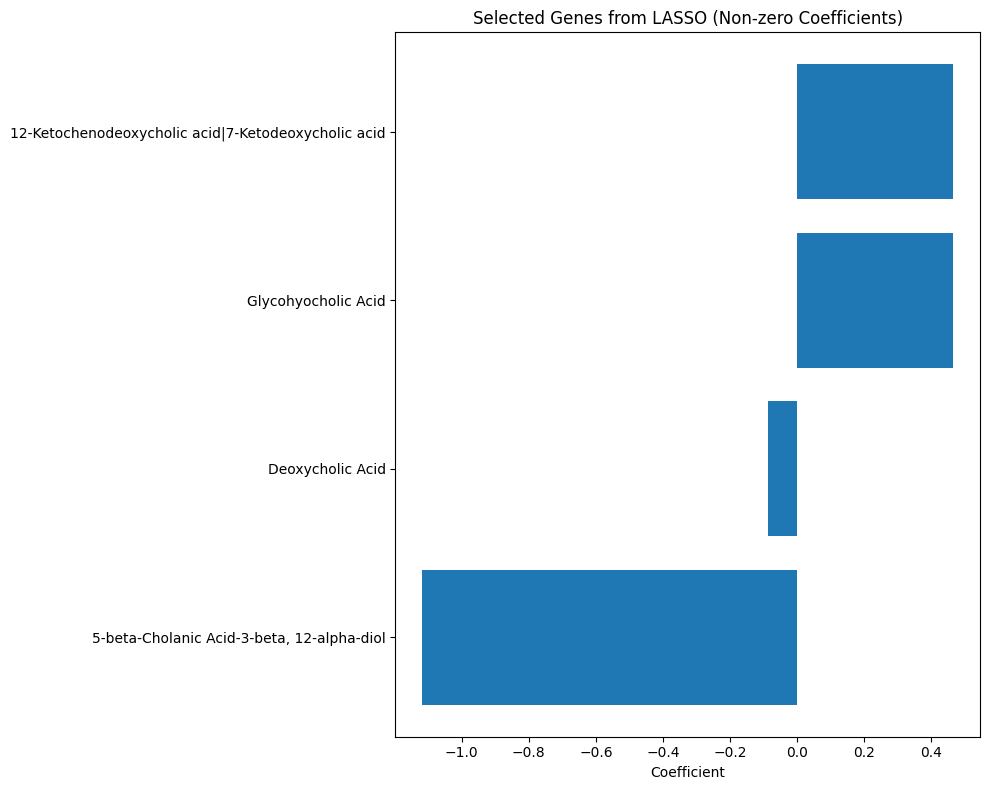

In [36]:
# Extract coefficients and feature names from the final model
coefs_LA = final_model_LA.named_steps['logisticregression'].coef_.flatten()
feature_names = log_x4_ml.columns

# Create a DataFrame of non-zero coefficients
selected = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefs_LA
})
#selected = selected[abs(selected['Coefficient'] != 0]
selected = selected [abs(selected['Coefficient']) > 1e-6].sort_values(by='Coefficient', ascending=False)
# Plot
plt.figure(figsize=(10, 8))
plt.barh(selected['Gene'], selected['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Selected Genes from LASSO (Non-zero Coefficients)")
plt.gca().invert_yaxis()  # Highest coefficient on top
plt.tight_layout()
plt.savefig("bile_lasso_coefficients.png")
plt.show()

## Elastic Net with LPOCV

In [39]:
patients = filtered_b4_clean['SampleID'].unique()

y_true_EN = []
y_pred_prob_EN = []
selected_genes_list_EN = []

for patient in patients:
    # Get boolean mask for train/test split
    test_mask = (filtered_b4_clean['SampleID'] == patient)
    train_mask = ~test_mask

    # Apply masks to feature matrix and labels
    X_train, X_test = log_x4_ml[train_mask], log_x4_ml[test_mask]
    y_train, y_test = y_4_ml[train_mask], y_4_ml[test_mask]


    # Inner loop for lambda selection
    inner_model_EN = LogisticRegressionCV(
        Cs=10,                      # Number of inverse lambdas to try
        cv=5,
        penalty='elasticnet',
        solver='saga',
        l1_ratios=[0.5],            
        scoring='accuracy',
        max_iter=10000,
        n_jobs=-1
    )

    pipeline_EN = make_pipeline(StandardScaler(), inner_model_EN)
    pipeline_EN.fit(X_train, y_train)


        # Get best parameters
    best_C_EN = inner_model_EN.C_[0]
    best_l1_ratio_EN = inner_model_EN.l1_ratio_[0]

    # Retrain final LA model on full training fold with best parameters
    final_model_EN = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty='elasticnet',
            C=best_C_EN,
            l1_ratio=best_l1_ratio_EN,
            solver='saga',
            max_iter=10000
        )
    )
    final_model_EN.fit(X_train, y_train)

    # Predict on left-out sample
    y_prob_EN = final_model_EN.predict_proba(X_test)[:, 1]
    y_pred_prob_EN.extend(y_prob_EN)
    y_true_EN.extend(y_test.tolist())

    # Get selected features
    coefs_EN = final_model_EN.named_steps['logisticregression'].coef_.flatten()
    selected_genes_EN = log_x4_ml.columns[coefs_EN != 0]
    selected_genes_list_EN.append(selected_genes_EN.tolist())

In [41]:
#Model Evaluation Metrics

y_pred_label_EN = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_EN]
# Accuracy
acc_EN = accuracy_score(y_true_EN, y_pred_label_EN)

# Sensitivity (Recall for class 1)
sensitivity_EN = recall_score(y_true_EN, y_pred_label_EN, pos_label=1)

# Specificity (Recall for class 0)
specificity_EN = recall_score(y_true_EN, y_pred_label_EN, pos_label=0)

# F1 Score
f1_EN = f1_score(y_true_EN, y_pred_label_EN)

# AUC
auc_EN = roc_auc_score(y_true_EN, y_pred_prob_EN)

# Confusion Matrix
cm_EN = confusion_matrix(y_true_EN, y_pred_label_EN)

# Print the results
print(f"Accuracy:    {acc_EN:.3f}")
print(f"Sensitivity: {sensitivity_EN:.3f}")
print(f"Specificity: {specificity_EN:.3f}")
print(f"F1 Score:    {f1_EN:.3f}")
print(f"AUC:         {auc_EN:.3f}")
print("Confusion Matrix:")
print(cm_EN)

Accuracy:    0.929
Sensitivity: 0.929
Specificity: 0.929
F1 Score:    0.929
AUC:         0.964
Confusion Matrix:
[[13  1]
 [ 1 13]]


In [43]:
# Convert to arrays
y_true_arr = np.array(y_true_EN)
y_score_arr = np.array(y_pred_prob_EN)

# Bootstrapping
n_bootstraps = 1000
rng = np.random.RandomState(42)
bootstrapped_aucs = []

for i in range(n_bootstraps):
    # Sample with replacement
    indices = rng.randint(0, len(y_score_arr), len(y_score_arr))
    if len(np.unique(y_true_arr[indices])) < 2:
        # Skip if bootstrap sample doesn't contain both classes
        continue

    score = roc_auc_score(y_true_arr[indices], y_score_arr[indices])
    bootstrapped_aucs.append(score)

# Convert to array
bootstrapped_aucs = np.array(bootstrapped_aucs)

# Calculate CI
mean_auc = roc_auc_score(y_true_arr, y_score_arr)
lower_ci = np.percentile(bootstrapped_aucs, 2.5)
upper_ci = np.percentile(bootstrapped_aucs, 97.5)

print(f"AUC (bootstrapped): {mean_auc:.3f} (95% CI: {lower_ci:.3f} – {upper_ci:.3f})")

AUC (bootstrapped): 0.964 (95% CI: 0.877 – 1.000)


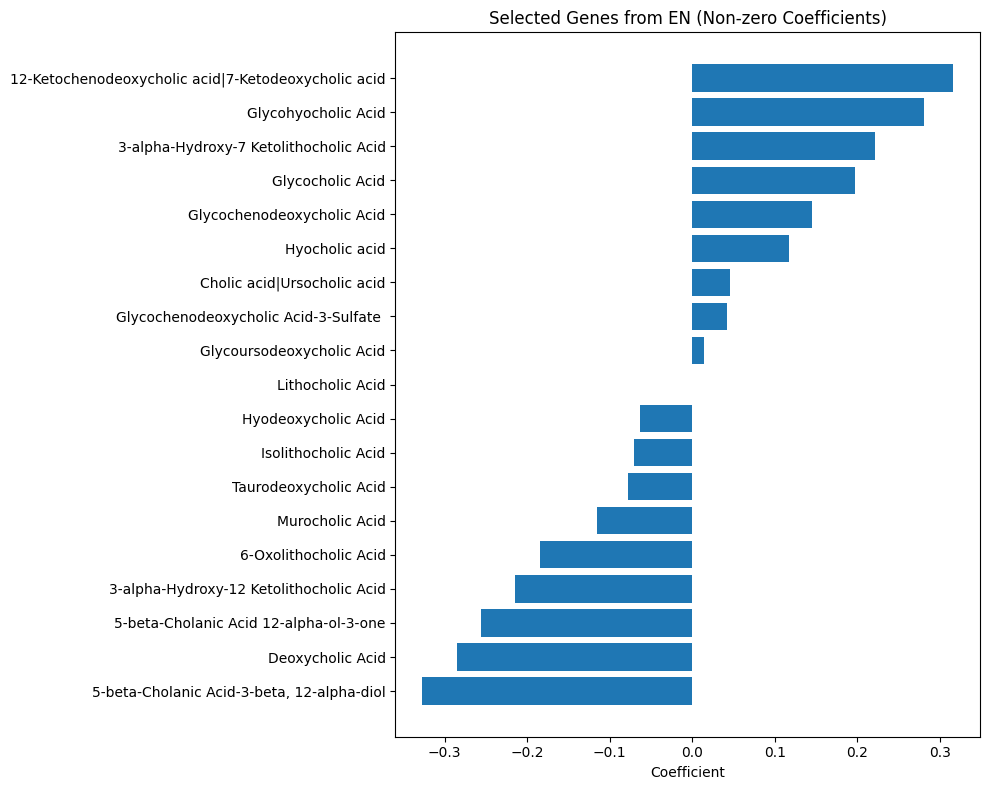

In [47]:
# Extract coefficients and feature names from the final model
coefs_EN = final_model_EN.named_steps['logisticregression'].coef_.flatten()
feature_names = log_x4_ml.columns

# Create a DataFrame of non-zero coefficients
selected_EN = pd.DataFrame({
    'Gene': feature_names,
    'Coefficient': coefs_EN
})
#selected = selected[abs(selected['Coefficient'] != 0]
selected_EN = selected_EN[abs(selected_EN['Coefficient']) > 1e-6].sort_values(by='Coefficient', ascending=False)
# Plot
plt.figure(figsize=(10, 8))
plt.barh(selected_EN['Gene'], selected_EN['Coefficient'])
plt.xlabel("Coefficient")
plt.title("Selected Genes from EN (Non-zero Coefficients)")
plt.gca().invert_yaxis()  # Highest coefficient on top
plt.tight_layout()
plt.savefig("bile_EN_Coefficients.png")
plt.show()

## Brouta + RF (Leave Pair out CV)

In [40]:
# Convert data to NumPy arrays
log_x4_ml= log_x4_ml.copy()
y_4_ml = np.array(y_4_ml)

patients = filtered_b4_clean['SampleID'].unique()

# Storage
y_true_all_RF = []
y_pred_all_RF = []
y_prob_all_RF = []
selected_feature_lists = []

for patient in patients:
    # Get boolean mask for train/test split
    test_mask = (filtered_b4_clean['SampleID'] == patient)
    train_mask = ~test_mask

    # Apply masks to feature matrix and labels
    X_train, X_test = log_x4_ml[train_mask], log_x4_ml[test_mask]
    y_train, y_test = y_4_ml[train_mask], y_4_ml[test_mask]


    # ✅ Scale training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ✅ Feature selection with Boruta
    model_rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    boruta = BorutaPy(
        estimator=model_rf,
        n_estimators='auto',
        max_iter=100,
        perc=100,
        verbose=0,
        random_state=42
    )
    boruta.fit(X_train_scaled, y_train)

    selected_idx = boruta.support_
    selected_feature_names = log_x4_ml.columns[selected_idx].tolist()
    selected_feature_lists.append(selected_feature_names)

    X_train_sel = boruta.transform(X_train_scaled)
    X_test_sel = boruta.transform(X_test_scaled)

    # ✅ Final model on selected features
    model_final = RandomForestClassifier(n_estimators=100, random_state=42)
    model_final.fit(X_train_sel, y_train)

    y_pred_RF = model_final.predict(X_test_sel)
    y_prob_RF = model_final.predict_proba(X_test_sel)[:, 1]

    y_true_all_RF.extend(y_test)
    y_pred_all_RF.extend(y_pred_RF)
    y_prob_all_RF.extend(y_prob_RF)

In [42]:
# Final evaluation
acc_RF = accuracy_score(y_true_all_RF, y_pred_all_RF)
f1_RF = f1_score(y_true_all_RF, y_pred_all_RF)
sensitivity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=1)
specificity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=0)
auc_RF = roc_auc_score(y_true_all_RF, y_prob_all_RF)
cm_RF = confusion_matrix(y_true_all_RF, y_pred_all_RF)

acc_RF = accuracy_score(y_true_all_RF, y_pred_all_RF)
f1_RF = f1_score(y_true_all_RF, y_pred_all_RF)
sensitivity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=1)
specificity_RF = recall_score(y_true_all_RF, y_pred_all_RF, pos_label=0)
auc_RF = roc_auc_score(y_true_all_RF, y_prob_all_RF)

print(f"\nAccuracy:    {acc_RF:.3f}")
print(f"F1 Score:    {f1_RF:.3f}")
print(f"Sensitivity: {sensitivity_RF:.3f}")
print(f"Specificity: {specificity_RF:.3f}")
print(f"AUC:         {auc_RF:.3f}")


Accuracy:    0.929
F1 Score:    0.929
Sensitivity: 0.929
Specificity: 0.929
AUC:         0.964


In [44]:
# Convert to arrays
y_true_arr = np.array(y_true_all_RF)
y_score_arr = np.array(y_prob_all_RF)

# Bootstrapping
n_bootstraps = 1000
rng = np.random.RandomState(42)
bootstrapped_aucs = []

for i in range(n_bootstraps):
    # Sample with replacement
    indices = rng.randint(0, len(y_score_arr), len(y_score_arr))
    if len(np.unique(y_true_arr[indices])) < 2:
        # Skip if bootstrap sample doesn't contain both classes
        continue

    score = roc_auc_score(y_true_arr[indices], y_score_arr[indices])
    bootstrapped_aucs.append(score)

# Convert to array
bootstrapped_aucs = np.array(bootstrapped_aucs)

# Calculate CI
mean_auc = roc_auc_score(y_true_arr, y_score_arr)
lower_ci = np.percentile(bootstrapped_aucs, 2.5)
upper_ci = np.percentile(bootstrapped_aucs, 97.5)

print(f"AUC (bootstrapped): {mean_auc:.3f} (95% CI: {lower_ci:.3f} – {upper_ci:.3f})")

AUC (bootstrapped): 0.964 (95% CI: 0.878 – 1.000)


In [46]:
#get the most selected features by brouta across each fold 

all_selected_features = list(chain.from_iterable(selected_feature_lists))

feature_counts = Counter(all_selected_features)

# Sort by most common
most_common_features = feature_counts.most_common()

print("\nMost frequently selected features across folds:")
for feature, count in most_common_features:
    print(f"{feature}: selected in {count} folds")


Most frequently selected features across folds:
Glycochenodeoxycholic Acid-3-Sulfate : selected in 28 folds
Deoxycholic Acid: selected in 28 folds
5-beta-Cholanic Acid 12-alpha-ol-3-one: selected in 28 folds
Glycochenodeoxycholic Acid: selected in 28 folds
3-alpha-Hydroxy-12 Ketolithocholic Acid: selected in 28 folds
Isolithocholic Acid: selected in 28 folds
Cholic acid|Ursocholic acid: selected in 28 folds
Glycocholic Acid: selected in 28 folds
6-Oxolithocholic Acid: selected in 28 folds
5-beta-Cholanic Acid-3-beta, 12-alpha-diol: selected in 28 folds
Lithocholic Acid: selected in 28 folds
3-Ketocholanic Acid: selected in 28 folds
Glycohyocholic Acid: selected in 28 folds
Hyodeoxycholic Acid: selected in 28 folds
Glycocholic Acid-3-Sulfate : selected in 28 folds
12-Ketochenodeoxycholic acid|7-Ketodeoxycholic acid: selected in 27 folds
Hyocholic acid: selected in 3 folds


## Evaluation metrics comparison

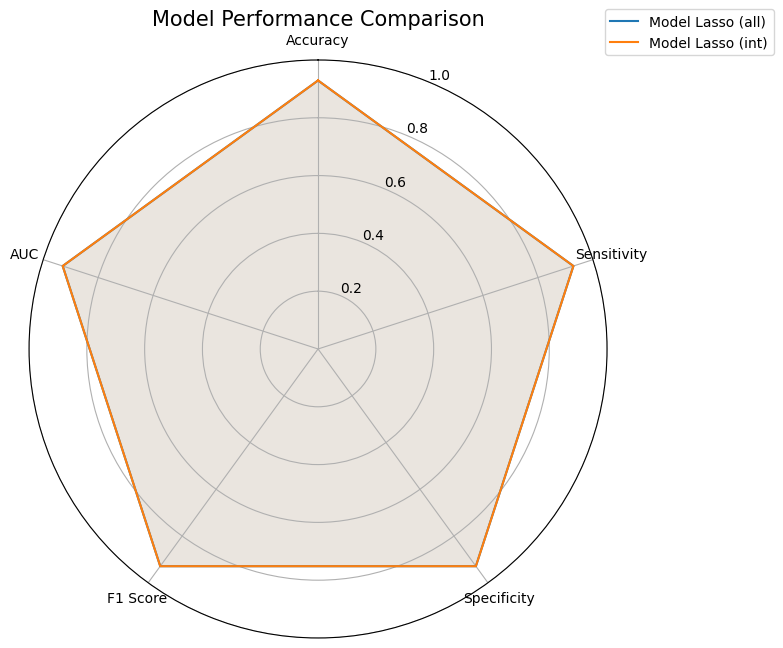

In [48]:
# Lasso Model

# Example data: 2 models and 5 metrics
data_lasso = {
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 'AUC'],
    'Model Lasso (all)': [0.929, 0.929, 0.929, 0.929, 0.929],
    'Model Lasso (int)': [0.929, 0.929, 0.929, 0.929, 0.929],
}

df = pd.DataFrame(data_lasso)
metrics = df['Metric'].tolist()
labels = np.array(metrics)
num_vars = len(labels)

# Angle for each metric
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Radar chart setup
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model
for model in df.columns[1:]:
    values = df[model].tolist()
    values += values[:1]  # repeat first value to close the loop
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

# Style settings
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
plt.title('Model Performance Comparison', size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("compare_between_lasso_bile.png")
plt.show()

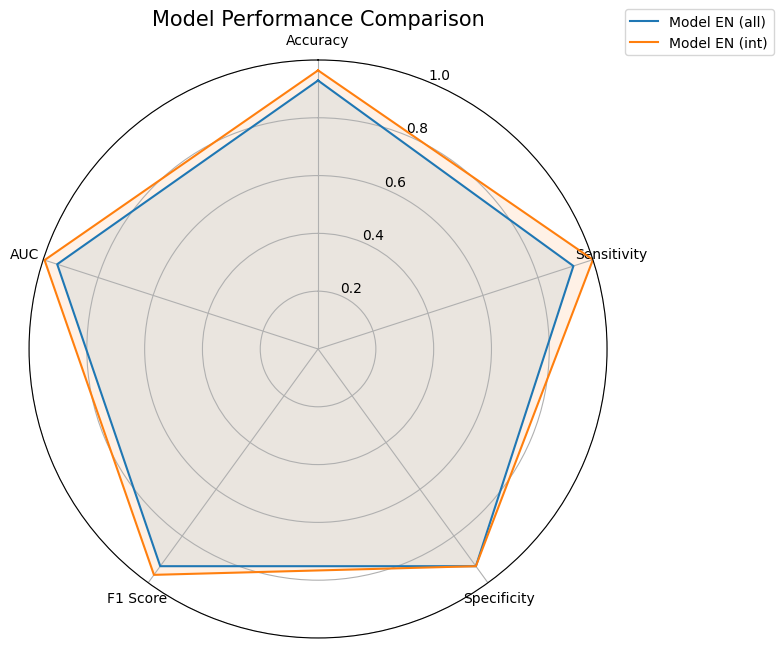

In [7]:
# EN-Model
        
# Example data: 2 models and 5 metrics
data_en = {
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 'AUC'],
    'Model EN (all)': [0.929, 0.929, 0.929, 0.929, 0.949],
    'Model EN (int)': [0.964, 1.000, 0.929, 0.966, 0.995],
}

df = pd.DataFrame(data_en)
metrics = df['Metric'].tolist()
labels = np.array(metrics)
num_vars = len(labels)

# Angle for each metric
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Radar chart setup
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model
for model in df.columns[1:]:
    values = df[model].tolist()
    values += values[:1]  # repeat first value to close the loop
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

# Style settings
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
plt.title('Model Performance Comparison', size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("compare_between_en_bile.png")
plt.show()

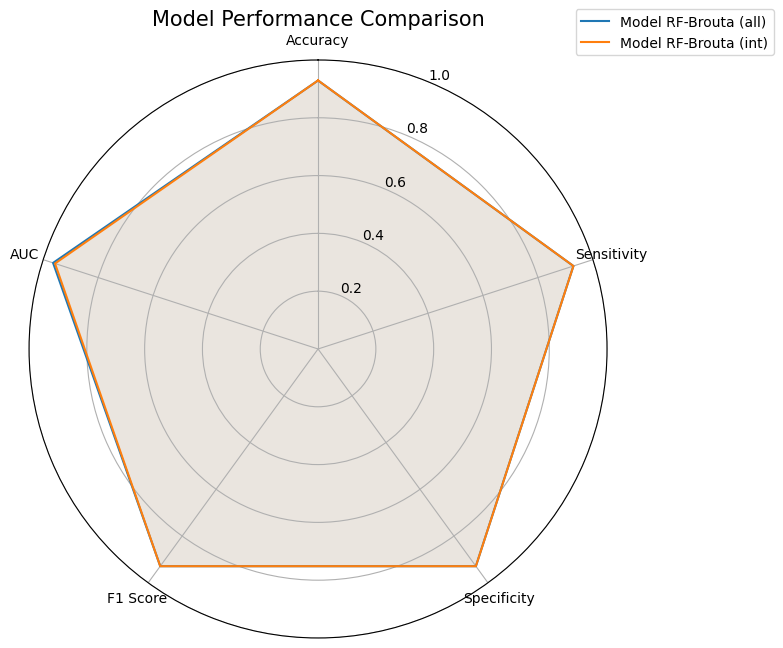

In [5]:
# Brouta-rf-Model

# Example data: 2 models and 5 metrics
data_rf = {
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 'AUC'],
    'Model RF-Brouta (all)': [0.929, 0.929, 0.929, 0.929, 0.964],
    'Model RF-Brouta (int)': [0.929, 0.929, 0.929, 0.929, 0.957],
}

df = pd.DataFrame(data_rf)
metrics = df['Metric'].tolist()
labels = np.array(metrics)
num_vars = len(labels)

# Angle for each metric
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

# Radar chart setup
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model
for model in df.columns[1:]:
    values = df[model].tolist()
    values += values[:1]  # repeat first value to close the loop
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

# Style settings
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
plt.title('Model Performance Comparison', size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("compare_between_rf_bile.png")
plt.show()